# Learning Notebook - SLU13 - Validation Metrics for Classification


The associated presentation of this Learning Notebook can be found [here](https://docs.google.com/presentation/d/1lEE9BUWsUKryXzGCLyysX7d78XL3ylANTU-fMKtIeYE/edit?usp=sharing).

By now you are already a fan of `scikit-learn`, or at least find it useful. It includes most of the **validation metrics for classification** you will ever use (which can mostly found [here](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). 

The validation metrics for classification presented in this notebook are:
- Accuracy Score
- Confusion Matrix
- Precision
- Recall
- F1-Score
- Area Under the Receiver Operating Charactristic curve (AUROC)

----
*By: [Hugo Lopes](https://www.linkedin.com/in/hugodlopes/)  
LDSA - SLU13*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The sklearn metrics:
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
    
from utils import plot_roc_curve

%matplotlib inline 

# Load some example _probas_
We will use already calculated scores/probabilities obtained by **`classif_model.predic_proba(X)`** to ease our work, where:
- `classif_model` is a scikit-learn classifier Class (e.g., `LogisticRegression()`)
- `predict_proba(X)` is the method that predicts the class probabilities for `X`

The example data (from binary classification), presented next, contains:
- Column 1: **`scores`** or *probas* (output of `predict_proba()`) in the range [0, 1] and they can be seen as probabilities.
- Column 2: **`target`** or actual outcome (a.k.a., labels - 0 or 1)

Time to load our `scores` and `probas`:

In [2]:
df_results = pd.read_csv('classifier_prediction_scores.csv')
print('Number of rows:', df_results.shape[0])
df_results.head()

Number of rows: 1250


,scores,target
0,0.288467,0
1,0.255047,1
2,0.201017,0
3,0.729307,1
4,0.148288,0


Let's take a look at the scores distribution - always a good idea as an Exploratory Data Analysis technique.

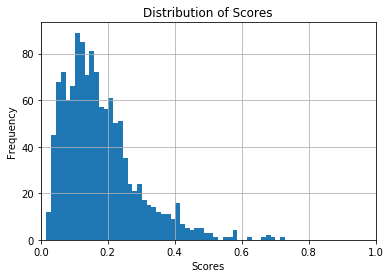

In [3]:
df_results['scores'].hist(bins=50)
plt.ylabel('Frequency')
plt.xlabel('Scores')
plt.title('Distribution of Scores')
plt.xlim(0, 1)
plt.show()

Makes sense since the output of `predict_proba()` are values in the range [0, 1]. Let's move to the metrics!

So we have a bunch of scores, which we can assume for ease of understanding that they are probabilities. 
So, we need to specify the **threshold** above which the predicted label is considered 1, then generate the predicted outcomes (0s or 1s):

In [7]:
# Set the threshold above which the values are set to 1
threshold = 0.50
# Generate the predicted labels (above threshold = 1, below = 0)
predicted_outcome = [0 if k <= threshold else 1 for k in df_results['scores']]

# Classification Metrics

## Confusion Matrix
The [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) *C* provides several performance indicators, useful in the calculation of several metrics we'll see next:
- C(0,0) - TN count
- C(1,0) - FN count
- C(0,1) - FP count
- C(1,1) - TP count

It is one of the most comprehensive ways to represent the result binary classification.

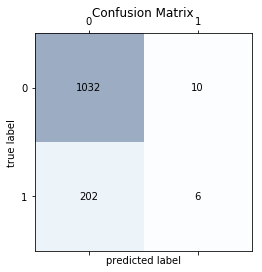

In [8]:
# Get the confusion matrix:
confmat = confusion_matrix(y_true=df_results['target'], y_pred=predicted_outcome)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
        s=confmat[i, j],
        va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')
plt.show()

As can be seen, the number of False Negatives is very high (202), which, depending on the business/application could be harmful.

## Accuracy score
The [**accuracy**](http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) is the fraction (default) or the count (normalize=False) of correct predictions. It is given by:  

$$ A = \frac{TP + TN}{TP + TN + FP + FN} $$

Where, $TP$ corresponds to the True Positives, $TN$ the True Negatives, $FP$ the False Positives, and $FN$ the False Negatives.

Main advantage of this metric is its simplicity and common understand of what it means for everyone. Disavantages of this metric:
- Not recommended its use in highly imbalanced datasets.
- You have to set a threshold for the output of the classifiers.

In [9]:
print('Accuracy = %2.3f' % accuracy_score(df_results['target'], predicted_outcome))

Accuracy = 0.830


Well, does not look that bad to have an **accuracy of 83%**. Let's continue...

## Precision, Recall and F1-score
- [**Precision**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) is the ability of the classifier not to label as positive a sample that is negative (i.e., a measure of result relevancy).
$$ P = \frac{TP}{TP+FP} $$  
  
  
- [**Recall**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) is the ability of the classifier to find all the positive samples (i.e., a measure of how many truly relevant results are returned).
$$ R = \frac{TP}{TP+FN} $$  
  
  
- [**F1 score**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) can be interpreted as a weighted harmonic mean of the precision and recall (in this case recall and precision are equally important).
$$ F1 = 2\frac{P \times R}{P+R} $$

For further information on precision, recall and f1-score click [here](http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures).

Always remember: _different metrics serve different purposes_. One of the most important issues is related with the balance of our binary classification problem. So, before computing any of the above metrics, let's check if our dataset has **class imbalance** (one of the classes, either 0 or 1, is present in the dataset in a much higher percentage than the other one):

In [10]:
df_results['target'].value_counts(normalize=True)

0    0.8336
1    0.1664
Name: target, dtype: float64

Quite imbalanced! Approximately 83% of the labels are 0. If you rely just on accuracy, then, if your classifier is simply dummy and output 0 at all times, you would have a very high 83% accuracy without any additional effort. 

Imagine a fraud application: the general case is to have 0.1 to 0.01%, or even less, positive (1 = fraud) outcomes. It means in this case you would have 99.9% or 99.99% accuracy - quite impressive right?


![shut up](https://i.imgflip.com/289ows.jpg)

**NO, IT IS NOT!**

Let's take a look at the **other metrics more appropriate for this type of (imbalanced) datasets**:

In [11]:
print('Precision score = %1.3f' % precision_score(df_results['target'], predicted_outcome))
print('Recall score = %1.3f' % recall_score(df_results['target'], predicted_outcome))
print('F1 score = %1.3f' % f1_score(df_results['target'], predicted_outcome))

Precision score = 0.375
Recall score = 0.029
F1 score = 0.054


As you can see, the results are not so good from other points of view. The ability of our classifier to find all the positive samples (Recall score) is extremelly low (2.9%)!

Time to explore a metric that you will hear a lot about, which is much more robust for imbalanced datasets...

## Receiver Operating Characteristic (ROC) and Area Under the ROC curve (AUROC)

The Receiver Operating Characteristic (ROC) curve is a very common (and important) metric for **binary classification problems**. 

**Formally**, it is created by plotting the fraction of true positives out of the positives (TPR = true positive rate, a.k.a., sensitivity) vs. the fraction of false positives out of the negatives (FPR = false positive rate, or 1-specificity), at various threshold settings. Sklearn already provide us with all the tools:


- The [**`roc_curve`**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) compute Receiver Operating Characteristic (ROC) curve points.
- The [**`roc_auc_score`**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) function computes the Area Under the ROC curve (AUROC). I.e., the curve information is summarized in one number.  

Take a look at an example ROC curve below ([source](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)):
!['ROC'](http://scikit-learn.org/stable/_images/sphx_glr_plot_roc_001.png)

The desired curve is one that gets to top left corner the fastest possible (which as you can imagine maximizes the area below it). So, an ideal AUROC curve (but I would say very suspicious as well) is 1.0, while in a completely random scenario we have an AUROC = 0.5. If you ever get an AUROC below 0.5 then something might be wrong since you are better of by having a random prediction than using your own classifier :)

Unlike the previous metrics, the ROC functions above require the actual scores/probabilities (and not the predicted labels).

## Intuition on ROC curve
Understanding what the ROC curve really means is not an easy task most of the times. Take a look at the next image to get some intuition.

!['ROC'](roc_curves_good_bad.png)

AUC ROC measures the ***ranking-ability*** of your classifier:
- if your classifer clearly separates both classes (0 and 1), then your AUROC is high (e.g., 0.85 in the image)
- if your classifier makes a mess out of the decision to be 0 or 1, then your will have a low AUROC (e.g., 0.58 in the image) meaning your classifer is close to random

The ideal situation would be **all** zeros on one side and **all** ones on the other (but this would be very suspicious for sure).


Let's calculate then the AU ROC of classifier:

In [12]:
# The Area Under the ROC curve:
roc_auc = roc_auc_score(df_results['target'], df_results['scores'])
print('The AU ROC of our classifier is = %.3f' % roc_auc)

The AU ROC of our classifier is = 0.698


Let's take a look at the ROC curve.

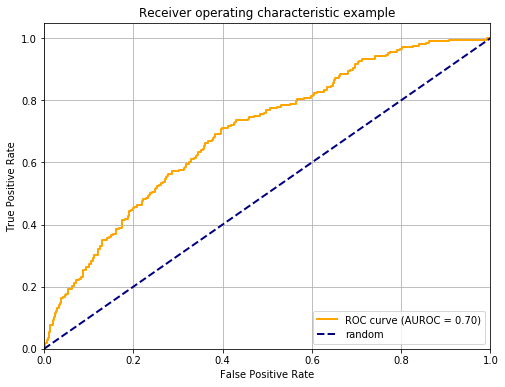

In [13]:
# Data to compute the ROC curve (FPR and TPR):
fpr, tpr, thresholds = roc_curve(df_results['target'], df_results['scores'])

plot_roc_curve(roc_auc, fpr, tpr)

As we can see, the AUROC is around 0.70. Making conclusions out of the Accuracy could have led us to make worng conclusions.